# Initial Investigations: Neural Networks with Uncertainty

This notebook explores building neural networks that provide uncertainty estimates and evaluates metrics that leverage these uncertainty measures.

## Importing all the libraries

In [265]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.datasets.mnist import load_data
from keras.utils import to_categorical
from keras.backend import clear_session
from math import log
from roby.EnvironmentRTest import EnvironmentRTest
from roby.Alterations import GaussianNoise, Alteration
from roby.RobustnessNN import robustness_test,\
    display_robustness_results, classification


## Loading the dataset

In [266]:
(x_train, y_train), (x_test, y_test) = load_data("mnist.npz")
# Normalize the data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Flatten the data (from 28x28 to 784)
flattened_input_shape = x_train[0].shape[0] * x_train[0].shape[1]
x_train = x_train.reshape((x_train.shape[0], flattened_input_shape))
x_test = x_test.reshape((x_test.shape[0], flattened_input_shape))
# Convert labels to one-hot encoding (needed for categorical crossentropy)
y_train_raw = y_train.copy()
y_test_raw = y_test.copy()
n_classes = len(np.unique(y_train))
y_train = to_categorical(y_train_raw, n_classes)
y_test = to_categorical(y_test_raw, n_classes)

## Building the model

In [267]:
model = keras.Sequential([
    Dense(units=16, input_shape=(flattened_input_shape,), activation="relu"), # hidden layer
    Dropout(0.5), # dropout to previous layer
    Dense(units=16, activation="relu"), # hidden layer
    Dense(units=n_classes, activation="softmax"), # output layer
])

## Compiling the model

In [268]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## Training the model

In [269]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
750/750 [==============================] - 1s 697us/step - loss: 1.2915 - accuracy: 0.5384 - val_loss: 0.4843 - val_accuracy: 0.8838
Epoch 2/10
750/750 [==============================] - 0s 601us/step - loss: 0.9242 - accuracy: 0.6664 - val_loss: 0.4124 - val_accuracy: 0.8964
Epoch 3/10
750/750 [==============================] - 0s 587us/step - loss: 0.8623 - accuracy: 0.6920 - val_loss: 0.3964 - val_accuracy: 0.9021
Epoch 4/10
750/750 [==============================] - 0s 594us/step - loss: 0.8239 - accuracy: 0.7113 - val_loss: 0.3824 - val_accuracy: 0.9043
Epoch 5/10
750/750 [==============================] - 0s 592us/step - loss: 0.7927 - accuracy: 0.7218 - val_loss: 0.3620 - val_accuracy: 0.9084
Epoch 6/10
750/750 [==============================] - 0s 586us/step - loss: 0.7794 - accuracy: 0.7297 - val_loss: 0.3456 - val_accuracy: 0.9103
Epoch 7/10
750/750 [==============================] - 0s 582us/step - loss: 0.7657 - accuracy: 0.7368 - val_loss: 0.3443 - val_accuracy:

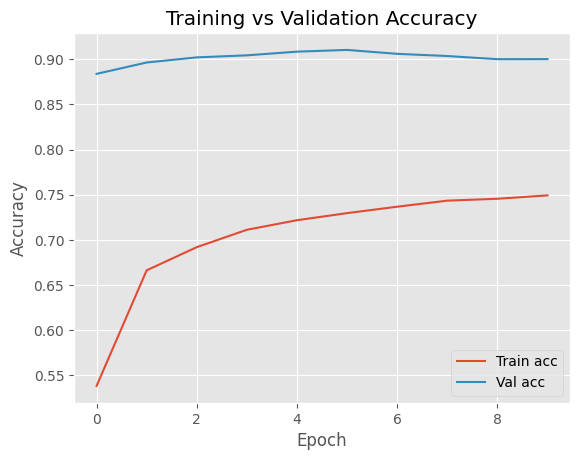

In [270]:
# Plot trainininng vs validation accuracy
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

## Computing uncertainty uncertainty as max probability complement on some examples

In [271]:
# Compute the uncerainty measure given a list of probabilities as the complement of the maximum probability
def compute_max_complement(prediction):
    return 1 - max(prediction)

In [272]:
# Predict and compute the uncertainty for the given input
def predict_with_max_complement(x):
    x = np.expand_dims(x, axis=0)  # adds batch dimension in position 0
    prediction = model.predict(x)[0] # x has to have batch dimension
    output = np.argmax(prediction)
    uncertainty = compute_max_complement(prediction)
    return output, uncertainty

In [273]:
# Compute the uncertainty for the first 4 images in the dataset
print("-- Max probability complement --")
for i in range(4):
    output, uncertainty = predict_with_max_complement(x_test[i])
    actual = np.argmax(y_test[i])
    print(f"Example {i}:")
    print(f"\tActual label: {actual} - Prediction: {output}")
    print(f"\tUncertainty: {uncertainty*100:.2f}%")

-- Max probability complement --
Example 0:
	Actual label: 7 - Prediction: 7
	Uncertainty: 1.03%
Example 1:
	Actual label: 2 - Prediction: 2
	Uncertainty: 6.30%
Example 2:
	Actual label: 1 - Prediction: 1
	Uncertainty: 3.52%
Example 3:
	Actual label: 0 - Prediction: 0
	Uncertainty: 5.43%


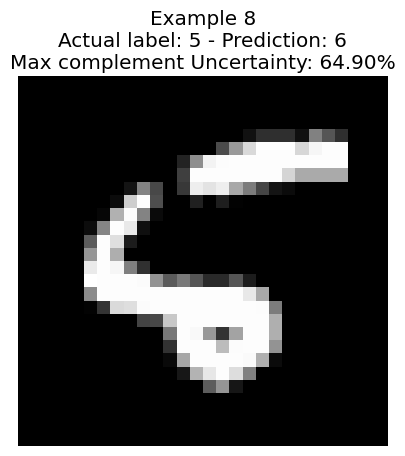

In [274]:
# Compute uncertainty for image 8 in the dataset, that shows to be complex to be predicted
output, uncertainty = predict_with_max_complement(x_test[8])
actual = np.argmax(y_test[8])
# Plot the image
plt.imshow(x_test[8].reshape(28, 28), cmap='gray')
plt.title(f"Example 8\nActual label: {actual} - Prediction: {output}\nMax complement Uncertainty: {uncertainty*100:.2f}%")
plt.axis('off')
plt.show()

## Computing uncecrtainty as entropy on some examples

In [275]:
# Compute the normalized entropy as uncerainty measure given a list of probabilities
def compute_entropy(prediction):
    entropy = 0
    for prob in prediction:
        if prob > 0:
            entropy += -prob*log(prob)
    entropy = entropy / log(len(prediction)) # Normalize entropy to get uncertainty
    return entropy

In [276]:
# Predict and compute the entropy (i.e., the uncertainty) for the given input
def predict_with_entropy(x):
    x = np.expand_dims(x, axis=0)  # adds batch dimension in position 0
    prediction = model.predict(x)[0] # x has to have batch dimension
    output = np.argmax(prediction)
    uncertainty = compute_entropy(prediction)
    return output, uncertainty

In [277]:
# Compute the entropy (i.e., the uncertainty) for the first 4 images in the dataset
print("-- Entropy --")
for i in range(4):
    output, uncertainty = predict_with_entropy(x_test[i])
    actual = np.argmax(y_test[i])
    print(f"Example {i}:")
    print(f"\tActual label: {actual} - Prediction: {output}")
    print(f"\tUncertainty: {uncertainty*100:.2f}%")

-- Entropy --
Example 0:
	Actual label: 7 - Prediction: 7
	Uncertainty: 2.95%
Example 1:
	Actual label: 2 - Prediction: 2
	Uncertainty: 12.63%
Example 2:
	Actual label: 1 - Prediction: 1
	Uncertainty: 9.00%
Example 3:
	Actual label: 0 - Prediction: 0
	Uncertainty: 11.04%


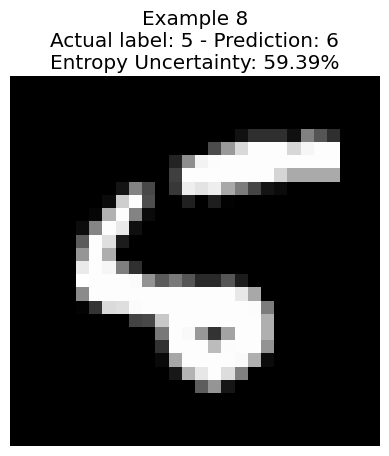

In [278]:
# Compute entropy for image 8 in the dataset, that shows to be complex to be predicted
output, uncertainty = predict_with_entropy(x_test[8])
actual = np.argmax(y_test[8])
# Plot the image
plt.imshow(x_test[8].reshape(28, 28), cmap='gray')
plt.title(f"Example 8\nActual label: {actual} - Prediction: {output}\nEntropy Uncertainty: {uncertainty*100:.2f}%")
plt.axis('off')
plt.show()

## Computing uncertainty using dropout on some examples

In [279]:
# Predict using Monte Carlo Dropout, also compute uncertainty as standard deviation 
def mc_dropout_prediction(model, x):
    x = np.expand_dims(x, axis=0)  # adds batch dimension in position 0
    prediction = np.array([model(x, training=True)[0] for _ in range(10)]) # run ten times enabling dropout
    mean = np.mean(prediction, axis=0)
    # Take the max probability for each run (usually associated with the same class)
    # and compute the standard deviation as uncerainty measure
    max_probs = np.max(prediction, axis=1)
    uncertainty = np.std(max_probs)
    return mean, uncertainty

In [280]:
# Predict using Monte Carlo Dropout, also compute uncertainty as standard deviation 
def mc_dropout_dataset_prediction(model, x):
    predictions = np.array([model(x, training=True) for _ in range(10)]) # run ten times enabling dropout
    means = np.mean(predictions, axis=0)
    # Take the max probability for each run (usually associated with the same class)
    # and compute the standard deviation as uncerainty measure
    max_probs = np.max(predictions, axis=2)
    uncertainties = np.std(max_probs, axis=0)
    return means, uncertainties

In [281]:
# Compute the uncertainty (with MC Dropout) for the first 4 images in the dataset
print("-- MC Dropout --")
for i in range(4):
    mean, uncertainty = mc_dropout_prediction(model, x=x_test[i])
    actual = np.argmax(y_test[i])
    output = np.argmax(mean)
    print(f"Example {i}:")
    print(f"\tActual label: {actual} - Prediction: {output}")
    print(f"\tUncertainty: {uncertainty*100:.2f}%")

-- MC Dropout --
Example 0:
	Actual label: 7 - Prediction: 7
	Uncertainty: 9.93%
Example 1:
	Actual label: 2 - Prediction: 2
	Uncertainty: 21.87%
Example 2:
	Actual label: 1 - Prediction: 1
	Uncertainty: 23.33%
Example 3:
	Actual label: 0 - Prediction: 0
	Uncertainty: 21.48%


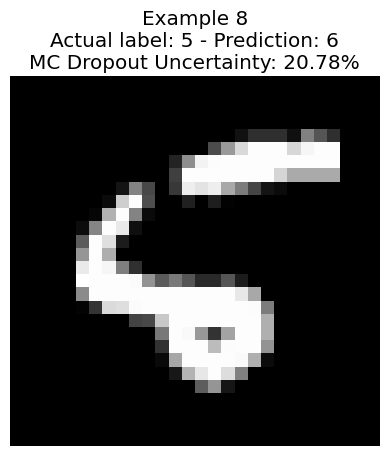

In [282]:
# Compute the uncertainty (with MC Dropout) for image 8 in the dataset, that shows to be complex to predict
mean, uncertainty = mc_dropout_prediction(model, x_test[8])
actual = np.argmax(y_test[8])
output = np.argmax(mean)
# Plot the image
plt.imshow(x_test[8].reshape(28, 28), cmap='gray')
plt.title(f"Example 8\nActual label: {actual} - Prediction: {output}\nMC Dropout Uncertainty: {uncertainty*100:.2f}%")
plt.axis('off')
plt.show()

## Computing uncertainty using ensamble on some examples

In [283]:
def reset_seeds(seed):
    clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Train n_models NNs with same structure but slightly different weight to do ensamble
def train_ensamble_models(model, n_models):
    models = [Sequential.from_config(model.get_config()) for _ in range(n_models)] # only works for Sequential for now
    models.append(model) # add the starting model
    for i, m in enumerate(models):
        reset_seeds(42 + i)
        m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
        m.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
    return models

In [284]:
# Predict using ensamble, also compute uncertainty as standard deviation 
def ensamble_prediction(models, x):
    x = np.expand_dims(x, axis=0)  # adds batch dimension in position 0
    prediction = np.array([model(x, training=False) for model in models])
    mean = np.mean(prediction, axis=0)
    # Take the max probability for each run (usually associated with the same class)
    # and compute the standard deviation as uncerainty measure
    max_probs = np.max(prediction, axis=1)
    uncertainty = np.std(max_probs)
    return mean, uncertainty

In [285]:
# Predict using ensamble, also compute uncertainty as standard deviation 
def ensamble_dataset_prediction(models, x):
    predictions = np.array([model.predict(x) for model in models])
    means = np.mean(predictions, axis=0)
    # Take the max probability for each run (usually associated with the same class)
    # and compute the standard deviation as uncerainty measure
    max_probs = np.max(predictions, axis=2)
    uncertainties = np.std(max_probs, axis=0)
    return means, uncertainties

In [286]:
# Train the ensamble models
models = train_ensamble_models(model, 10)

Epoch 1/10
750/750 [==============================] - 1s 699us/step - loss: 1.2745 - accuracy: 0.5369 - val_loss: 0.5480 - val_accuracy: 0.8740
Epoch 2/10
750/750 [==============================] - 0s 596us/step - loss: 0.9210 - accuracy: 0.6748 - val_loss: 0.4355 - val_accuracy: 0.8906
Epoch 3/10
750/750 [==============================] - 0s 590us/step - loss: 0.8529 - accuracy: 0.7059 - val_loss: 0.3988 - val_accuracy: 0.8943
Epoch 4/10
750/750 [==============================] - 0s 600us/step - loss: 0.8138 - accuracy: 0.7215 - val_loss: 0.3849 - val_accuracy: 0.9016
Epoch 5/10
750/750 [==============================] - 0s 595us/step - loss: 0.7781 - accuracy: 0.7358 - val_loss: 0.3671 - val_accuracy: 0.8988
Epoch 6/10
750/750 [==============================] - 0s 589us/step - loss: 0.7481 - accuracy: 0.7484 - val_loss: 0.3491 - val_accuracy: 0.9028
Epoch 7/10
750/750 [==============================] - 0s 575us/step - loss: 0.7324 - accuracy: 0.7569 - val_loss: 0.3611 - val_accuracy:

In [287]:
# Compute the uncertainty (with ensamble) for the first 4 images in the dataset
print("-- Ensamble --")
for i in range(4):
    mean, uncertainty = ensamble_prediction(models, x=x_test[i])
    actual = np.argmax(y_test[i])
    output = np.argmax(mean)
    print(f"Example {i}:")
    print(f"\tActual label: {actual} - Prediction: {output}")
    print(f"\tUncertainty: {uncertainty*100:.2f}%")

-- Ensamble --
Example 0:
	Actual label: 7 - Prediction: 7
	Uncertainty: 29.83%
Example 1:
	Actual label: 2 - Prediction: 2
	Uncertainty: 28.42%
Example 2:
	Actual label: 1 - Prediction: 1
	Uncertainty: 29.17%
Example 3:
	Actual label: 0 - Prediction: 0
	Uncertainty: 28.21%


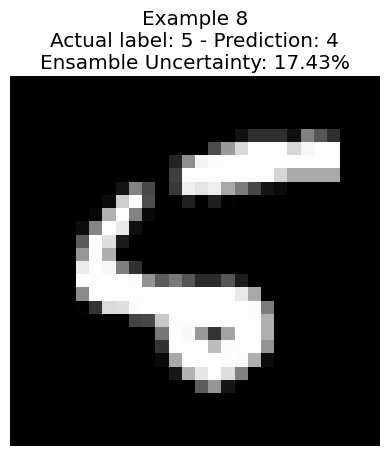

In [288]:
# Compute the uncertainty (with MC Dropout) for image 8 in the dataset, that shows to be complex to predict
mean, uncertainty = ensamble_prediction(models, x_test[8])
actual = np.argmax(y_test[8])
output = np.argmax(mean)
# Plot the image
plt.imshow(x_test[8].reshape(28, 28), cmap='gray')
plt.title(f"Example 8\nActual label: {actual} - Prediction: {output}\nEnsamble Uncertainty: {uncertainty*100:.2f}%")
plt.axis('off')
plt.show()

## Computing proposed accuracy metrics on test dataset

In [289]:
# Compute the three accuracies given the prediction, the uncertainties, the correct labeks, and the threshold
def compute_accuracies(predictions, uncertainty, correct_labels, threshold):
    is_label_ok = [1 if np.argmax(pred) == np.argmax(actual) else 0 for pred, actual in zip(predictions, correct_labels)]
    num_was, num_bomb, den_was = 0, 0, 0
    for i in range(len(is_label_ok)):
        num_bomb += is_label_ok[i] * (1-uncertainty[i]) + (1-is_label_ok[i]) * uncertainty[i]
        if uncertainty[i] < threshold:
            num_was += is_label_ok[i]
            den_was += 1

    acc_trad = sum(is_label_ok)/len(is_label_ok)
    acc_bomb = num_bomb/len(is_label_ok)
    if den_was > 0: 
        acc_was = num_was/den_was

    print(f"Traditional accuracy:\t{acc_trad*100:.2f}%")
    print(f"Bombarda accuracy:\t{acc_bomb*100:.2f}%")
    if den_was > 0: 
        print(f"Wasim accuracy:\t\t{acc_was*100:.2f}%")
    else:
        print(f"Wasim accuracy:\t\tundefined")

In [290]:
# Compute an approximation Uncertainty ROC given the prediction, the uncertainties, the correct labeks, and the number of points (thresholds) to use.
# The additional point (0,0) is added
def compute_uroc(predictions, uncertainties, correct_labels, n_thresholds):
    is_label_ok = [1 if np.argmax(pred) == np.argmax(actual) else 0 for pred, actual in zip(predictions, correct_labels)]
    thresholds = [i/n_thresholds for i in range(n_thresholds, -1, -1)]
    points = [(_,_) for _ in range(n_thresholds, -1, -1)]
    for i in range(n_thresholds+1):
        wrong = 0
        correct = 0
        unknown_on_wrong = 0
        unknown_on_correct = 0
        is_unknown = [1 if uncertainty > thresholds[i] else 0 for uncertainty in uncertainties]
        for j in range(len(is_label_ok)):
            if is_label_ok[j] == 1:
                correct += 1
                if is_unknown[j] == 1:
                    unknown_on_correct += 1
            else:
                wrong += 1
                if is_unknown[j] == 1:
                    unknown_on_wrong += 1
        points[i] = (unknown_on_correct/correct, unknown_on_wrong/wrong)
    return points
    
# Plot the Uncertainty ROC
def plot_uroc(points):
    x, y = zip(*points)
    plt.figure(figsize=(4, 4))
    plt.plot(x, y, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Unknown on correct rate')
    plt.ylabel('Unknown on wrong rate')
    plt.title('Uncertainty ROC Curve')
    plt.grid(False)
    plt.fill_between(x, y, alpha=0.2)
    plt.show()

# Compute the AU Uncertainty ROC
def compute_au_uroc(points):
    x, y = zip(*points)
    area = np.trapz(np.array(y), np.array(x))
    print(f"Area Under UROC:\t{area*100:.2f}%")

In [291]:
threshold = 0.3 # output labeled as unknown if uncertainty is greater than 30%
roc_n_points = 10 

With max probability complement
Traditional accuracy:	87.32%
Bombarda accuracy:	81.52%
Wasim accuracy:		95.02%
Area Under UROC:	86.33%


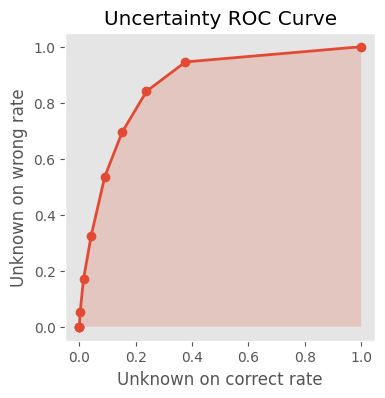

In [292]:
# Predict deterministically using the model and compute uncertainty using max probability complement
predictions = model.predict(x_test)
uncertainty = [compute_max_complement(pred) for pred in predictions]
print(f"With max probability complement")
compute_accuracies(predictions, uncertainty, y_test, threshold)
curve = compute_uroc(predictions, uncertainty, y_test, roc_n_points)
compute_au_uroc(curve)
plot_uroc(curve)

With entropy
Traditional accuracy:	87.32%
Bombarda accuracy:	78.15%
Wasim accuracy:		95.76%
Area Under UROC:	85.55%


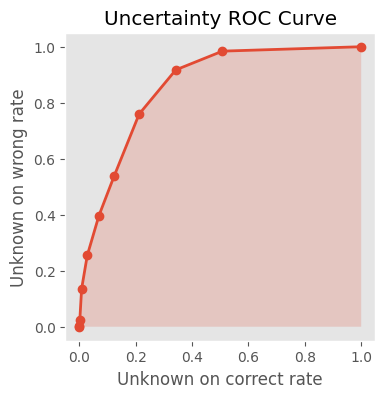

In [293]:
# Predict deterministically using the model and compute uncertainty using entropy
predictions = model.predict(x_test)
uncertainty = [compute_entropy(pred) for pred in predictions]
print(f"With entropy")
compute_accuracies(predictions, uncertainty, y_test, threshold)
curve = compute_uroc(predictions, uncertainty, y_test, roc_n_points)
compute_au_uroc(curve)
plot_uroc(curve)

With MC Dropout
Traditional accuracy:	91.20%
Bombarda accuracy:	75.61%
Wasim accuracy:		90.98%
Area Under UROC:	39.38%


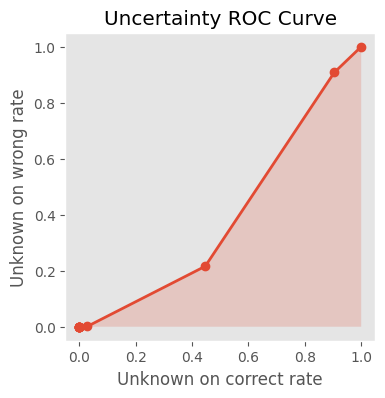

In [294]:
# Predict non deterministically using MC Dropout, that also gives the uncetainty
predictions, uncertainty = mc_dropout_dataset_prediction(model, x_test)
print(f"With MC Dropout")
compute_accuracies(predictions, uncertainty, y_test, threshold)
curve = compute_uroc(predictions, uncertainty, y_test, roc_n_points)
compute_au_uroc(curve)
plot_uroc(curve)

With Ensamble
Traditional accuracy:	92.36%
Bombarda accuracy:	85.14%
Wasim accuracy:		92.36%
Area Under UROC:	71.79%


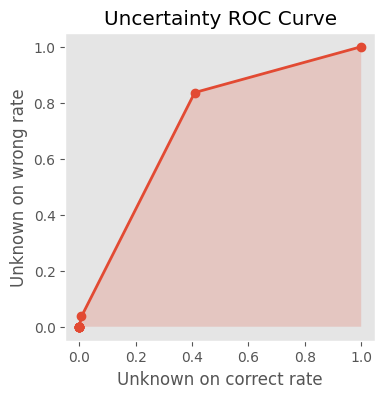

In [295]:
# Predict deterministically using ensamble that also gives the uncetainty
predictions, uncertainty = ensamble_dataset_prediction(models, x_test)
print(f"With Ensamble")
compute_accuracies(predictions, uncertainty, y_test, threshold)
curve = compute_uroc(predictions, uncertainty, y_test, roc_n_points)
compute_au_uroc(curve)
plot_uroc(curve)

## Using Roby to compute robustness

In [296]:
def pre_processing(image):
    return image.reshape(1, 784)

Successes: 182
Failures: 18
Accuracy: 0.91
[2025-07-31 12:44:44.807209]: Starting alteration GaussianNoise
[2025-07-31 12:46:28.962765]: Ending alteration GaussianNoise
Robustness w.r.t GaussianNoise: 1.0


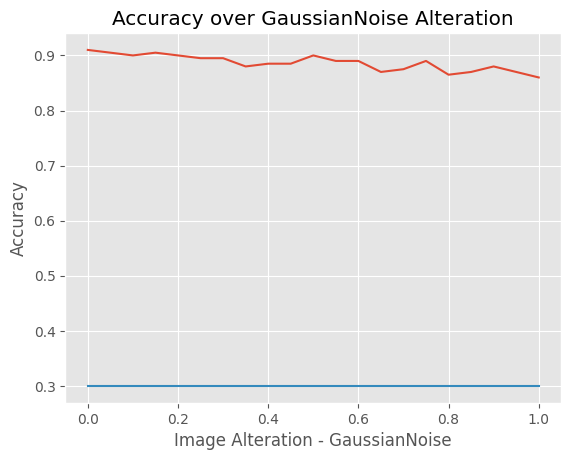

In [297]:
x_test_reshaped = x_test.reshape((-1, 28, 28, 1))

# set the classes
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

# load the environment
environment = EnvironmentRTest(model, x_test_reshaped[:200], classes, preprocess_f=pre_processing, label_list=y_test_raw[:200])

# get the standard behavior of the net
accuracy = classification(environment)

# create the alteration_type as a GaussianNoise with variance 0.01
alteration_type: Alteration = GaussianNoise(0, 1, 0.01)

# perform robustness analysis, with 20 points
results = robustness_test(environment, alteration_type, 20, threshold)
display_robustness_results(results)